In [1]:
import numpy as np
from numpy import (fft, random)
from matplotlib import pyplot as plt

In [2]:
from scipy.integrate import quad

In [3]:
def eisenstein_hu(Theta27, Omega0, h, **kwargs):
    Gamma = Omega0 * h
    
    def L0(q):
        return np.log(2*np.exp(1) + 1.8*q)
    
    def C0(q):
        return 14.2 + 731 / (1 + 62.5 * q)
    
    def T0(k):
        q = k * Theta27**2 / Gamma
        return L0(q) / (L0(q) + C0(q) * q**2)
    
    return T0

In [4]:
def cdm(ns, T0, A=1.0, **kwargs):
    return lambda k: A * k**ns * T0(k)**2

In [5]:
def W_th(y):
    return 3 / y**3 * (np.sin(y) - y * np.cos(y))

In [412]:
def norm_integrant(P, R):
    return lambda k: P(k) / (2 * np.pi**2) * W_th(R * k)**2 * k**2

In [486]:
class Cosmology(dict):
    def __init__(self, **kwargs):
        for key, val in kwargs.items():
            self[key] = val
        self.normalise()
            
    def __getattr__(self, key):
        return self[key]
    
    def __setattr__(self, key, val):
        self[key] = val
        
    def P(self, k):
        return cdm(T0=eisenstein_hu(**self), **self)(k)

    @property
    def shape(self):
        return (self.N,) * 3
    
    @property
    def V(self):
        return self.L**3
    
    @property
    def freq(self):
        N = self.N
        L = self.L
        return fft.fftfreq(N, L/(2 * np.pi * N))
    
    @property
    def k(self):
        return self.freq[np.indices(self.shape)]
    
    @property
    def k_abs(self):
        return np.sqrt((self.k**2).sum(axis=0))

    def normalise(self):
        self.A = 1.0
        self.A = self.sigma8**2 / quad(
            norm_integrant(self.P, 8.0),
            (2*np.pi)/self.L,
            np.inf)[0]
        
cosmology = Cosmology(
    h=0.674,
    ns=0.965,
    Omega0=1.000,
    sigma8=0.811,
    Theta27=2.7255/2.7,
    N=128,
    L=100.0,
    A=1.0)

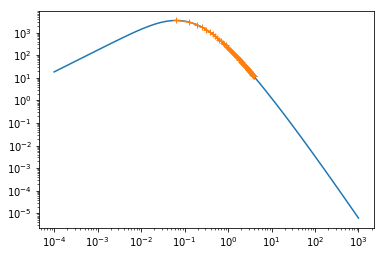

In [487]:
N = cosmology.N
k = np.logspace(-4, 3, 100)
kx = cosmology.freq[1:N//2]
plt.loglog(k, cosmology.P(k))
plt.loglog(kx, cosmology.P(kx), marker='+')

# Accuracy of the integral method

In [364]:
s = []
for i in np.arange(2, 8):
    N = 2**i
    for L in random.uniform(10.0, 500.0, 10):
        cosmology.L = L
        cosmology.N = N

        k = cosmology.k_abs.flat[1:]
        cosmology.A = 1.0
        cosmology.A = cosmology.sigma8**2 / quad(norm_integrant(cosmology.P, 8.0),
                  (2*np.pi)/cosmology.L,
                  np.inf)[0]

        s.append([N, L, np.sqrt(1. / cosmology.V * np.sum(cosmology.P(k) * W_th(8.0 * k)**2))])

In [365]:
s = np.array(s)

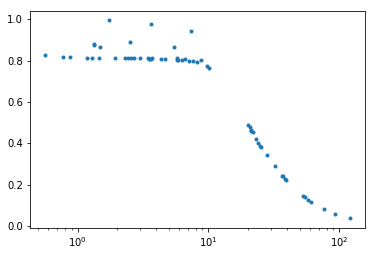

In [366]:
plt.semilogx(s[:,1] / s[:,0], s[:,2], '.')

# Look at the shape of W_th

In [643]:
w = W_th(25 * cosmology.k_abs)

/home/johannes/.local/share/workon/cosmology/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/johannes/.local/share/workon/cosmology/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


In [644]:
w[0,0,0] = 1.0

In [651]:
N = cosmology.N
# f = np.zeros(shape=cosmology.shape)
f = random.normal(size=cosmology.shape)
# f[N//2,N//2,N//2] = 1.0
g = fft.ifftn(fft.fftn(f) * w).real

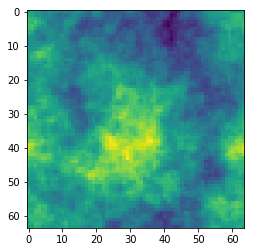

In [652]:
plt.imshow(g[N//2])

In [655]:
f.std()

0.9997366096599325

In [656]:
g.std()

0.011658322776161125

# Measuring the Power spectrum of a field

In [759]:
cosmology = Cosmology(
    h=0.674,
    ns=0.965,
    Omega0=1.000,
    sigma8=0.811,
    Theta27=2.7255/2.7,
    N=128,
    L=100.0,
    A=1.0)

print(cosmology.A)

131767.1613554223


In [760]:
N = cosmology.N
L = cosmology.L
k = cosmology.k_abs
i = np.argsort(k.flatten())

f = random.normal(0.0, 1.0, size=cosmology.shape)
d = fft.ifftn(fft.fftn(f) * np.sqrt(cosmology.P(k) * (N / L)**3)).real

In [761]:
F = fft.fftn(d) / N**(3/2)
P = (F * F.conj()).real * (L / N)**3

y = P.flat[i].reshape(N, -1).std(axis=1)
x = k.flat[i].reshape(N, -1).mean(axis=1)

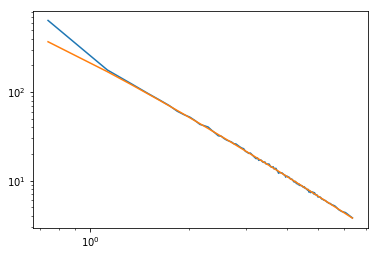

In [762]:
plt.loglog(x, y)
plt.loglog(x, cosmology.P(x))

# Measure $\sigma_8$

In [763]:
d.std()

6.766621033648014

In [764]:
w = W_th(8.0 * cosmology.k_abs) ; w[0,0,0] = 1.0
g = fft.ifftn(fft.fftn(d) * w).real

/home/johannes/.local/share/workon/cosmology/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/johannes/.local/share/workon/cosmology/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


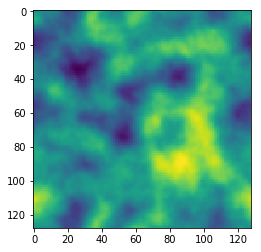

In [765]:
plt.imshow(g[N//2])

In [766]:
g.std()

0.8047898713258607

In [747]:
s = []
cosmology.N = 64
for res in np.logspace(-2, 1, 21):
    cosmology.L = cosmology.N * res
    cosmology.normalise()
    N = cosmology.N
    L = cosmology.L
    k = cosmology.k_abs
    # i = np.argsort(k.flatten())

    q = []
    for j in range(10):
        f = random.normal(0.0, 1.0, size=cosmology.shape)
        w = W_th(8.0 * cosmology.k_abs) ; w[0,0,0] = 1.0
        d = fft.ifftn(fft.fftn(f) * np.sqrt(cosmology.P(k) * (N/L)**3) * w).real
        q.append(d.std())
    
    s.append(q)
s = np.array(s)

/home/johannes/.local/share/workon/cosmology/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/johannes/.local/share/workon/cosmology/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


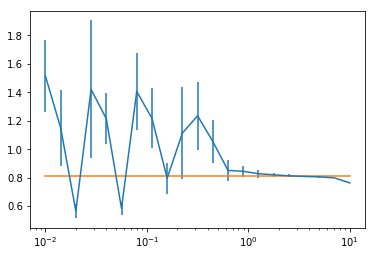

In [750]:
fig, ax = plt.subplots(1, 1)
ax.set_xscale("log", nonposx='clip')
# ax.set_yscale("log", nonposy='clip')
x = np.logspace(-2, 1, 21)
ax.errorbar(x, s.mean(axis=1), yerr=s.std(axis=1))
ax.plot(x, 0.811 * np.ones_like(x))